# Figure 1b, amino acids inserted and deleted

In [1]:
%run ../../shared_setup.ipynb

docker image cggh/biipy:v1.6.0


In [3]:
# N.B., there is a bug in the version of SNPEFF used to annotate the VCFs
# so we work around here by using a different implementation veff available
# from http://github.com/alimanfoo/veff
sys.path.insert(0, '/home/aliman/code/github/alimanfoo/veff')
%load_ext autoreload
%autoreload 1
%aimport veff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# setup reference genome
genome = veff.Genome(FASTA_FN, GFF_FN)

In [6]:
# define a function to build a table of variants and their effects

def tabulate_indel_effects(cross):
    
    # VCF file name
    vcf_fn = COMBINED_VCF_FN_TEMPLATE.format(cross=cross)
    
    # build the table
    tbl = (etl
        .fromvcf(vcf_fn, samples=None)
        # only take PASS variants
        .false('FILTER')
        # choose only biallelic variants
        .select('ALT', lambda v: len(v) == 1)
        # unpack alternate alleles
        .unpack('ALT', ['ALT1'])
        # add effects
        .addfield('veff1', lambda row: list(veff.get_effects(genome, row.CHROM, row.POS, row.REF, row.ALT1)))
        # assume a single effect
        .convert('veff1', lambda v: v[0] if v else None)
        # choose only indel in-frame coding effects
        .select('veff1', lambda v: v.effect in {'CODON_DELETION', 
                                                'CODON_CHANGE_PLUS_CODON_DELETION',
                                                'CODON_INSERTION',
                                                'CODON_CHANGE_PLUS_CODON_INSERTION'})
        # count amino acids inserted and deleted
        .addfield('aa_ins', lambda row: collections.Counter(row.veff1.alt_aa) - collections.Counter(row.veff1.ref_aa))
        .addfield('aa_del', lambda row: collections.Counter(row.veff1.ref_aa) - collections.Counter(row.veff1.alt_aa))
        # exclude fields not needed in this analysis
        .cutout('ID', 'REF', 'ALT1', 'QUAL', 'FILTER', 'INFO')
        
    )
    
    return tbl

In [7]:
tbl_effects = tabulate_indel_effects('3d7_hb3')
tbl_effects

0|CHROM,1|POS,2|veff1,3|aa_ins,4|aa_del
Pf3D7_01_v3,101790,"VariantEffect(effect='CODON_DELETION', impact='MODERATE', chrom='Pf3D7_01_v3', pos=101790, ref='AAAT', alt='A', vlen=-3, ref_start=101790, ref_stop=101793, gene_id='PF3D7_0102200', gene_start=98819, gene_stop=102282, gene_strand='+', transcript_id='PF3D7_0102200.1', transcript_start=98819, transcript_stop=102282, transcript_strand='+', cds_id='PF3D7_0102200.1:exon:2', cds_start=99220, cds_stop=102282, cds_strand='+', ref_cds_start=2765, ref_cds_stop=2768, ref_start_phase=2, ref_codon='gaAAAT', alt_codon='gaA', codon_change='gaAAAT/gaA', aa_pos=922, ref_aa='EN', alt_aa='E', aa_change='EN922E')",Counter(),Counter({'N': 1})
Pf3D7_01_v3,127256,"VariantEffect(effect='CODON_DELETION', impact='MODERATE', chrom='Pf3D7_01_v3', pos=127256, ref='AATT', alt='A', vlen=-3, ref_start=127256, ref_stop=127259, gene_id='PF3D7_0102800', gene_start=126318, gene_stop=128141, gene_strand='-', transcript_id='PF3D7_0102800.1', transcript_start=126318, transcript_stop=128141, transcript_strand='-', cds_id='PF3D7_0102800.1:exon:3', cds_start=126318, cds_stop=128141, cds_strand='-', ref_cds_start=882, ref_cds_stop=885, ref_start_phase=0, ref_codon='AATTgt', alt_codon='Tgt', codon_change='AATTgt/Tgt', aa_pos=295, ref_aa='NC', alt_aa='C', aa_change='NC295C')",Counter(),Counter({'N': 1})
Pf3D7_01_v3,127692,"VariantEffect(effect='CODON_INSERTION', impact='MODERATE', chrom='Pf3D7_01_v3', pos=127692, ref='G', alt='GTTATTA', vlen=6, ref_start=127692, ref_stop=127692, gene_id='PF3D7_0102800', gene_start=126318, gene_stop=128141, gene_strand='-', transcript_id='PF3D7_0102800.1', transcript_start=126318, transcript_stop=128141, transcript_strand='-', cds_id='PF3D7_0102800.1:exon:3', cds_start=126318, cds_stop=128141, cds_strand='-', ref_cds_start=449, ref_cds_stop=449, ref_start_phase=2, ref_codon='aaC', alt_codon='aaTAATAAC', codon_change='aaC/aaTAATAAC', aa_pos=150, ref_aa='N', alt_aa='NNN', aa_change='N150NNN')",Counter({'N': 2}),Counter()
Pf3D7_01_v3,135874,"VariantEffect(effect='CODON_DELETION', impact='MODERATE', chrom='Pf3D7_01_v3', pos=135874, ref='ATTTTCCTTTTCC', alt='A', vlen=-12, ref_start=135874, ref_stop=135886, gene_id='PF3D7_0103100', gene_start=134353, gene_stop=139257, gene_strand='-', transcript_id='PF3D7_0103100.1', transcript_start=134353, transcript_stop=139257, transcript_strand='-', cds_id='PF3D7_0103100.1:exon:1', cds_start=134353, cds_stop=139257, cds_strand='-', ref_cds_start=3371, ref_cds_stop=3383, ref_start_phase=2, ref_codon='aaGGAAAAGGAAAAT', alt_codon='aaT', codon_change='aaGGAAAAGGAAAAT/aaT', aa_pos=1124, ref_aa='KEKEN', alt_aa='N', aa_change='KEKEN1124N')",Counter(),"Counter({'K': 2, 'E': 2})"
Pf3D7_01_v3,137201,"VariantEffect(effect='CODON_DELETION', impact='MODERATE', chrom='Pf3D7_01_v3', pos=137201, ref='ATAT', alt='A', vlen=-3, ref_start=137201, ref_stop=137204, gene_id='PF3D7_0103100', gene_start=134353, gene_stop=139257, gene_strand='-', transcript_id='PF3D7_0103100.1', transcript_start=134353, transcript_stop=139257, transcript_strand='-', cds_id='PF3D7_0103100.1:exon:1', cds_start=134353, cds_stop=139257, cds_strand='-', ref_cds_start=2053, ref_cds_stop=2056, ref_start_phase=1, ref_codon='aATATa', alt_codon='aTa', codon_change='aATATa/aTa', aa_pos=685, ref_aa='NI', alt_aa='I', aa_change='NI685I')",Counter(),Counter({'N': 1})


In [8]:
from functools import reduce

In [9]:
count_aa_ins = dict()
count_aa_del = dict()
for cross in CROSSES:
    log(cross)
    tbl_effects = tabulate_indel_effects(cross)
    count_aa_ins[cross] = reduce(operator.add, tbl_effects.values('aa_ins'))
    count_aa_del[cross] = reduce(operator.add, tbl_effects.values('aa_del'))
    

2016-06-15 12:28:31.759655 :: 3d7_hb3
2016-06-15 12:29:14.649307 :: hb3_dd2
2016-06-15 12:30:04.959560 :: 7g8_gb4


In [10]:
def plot_indel_aa_frequencies(ax, cross=None):
    
    if cross:
        aa_ins = count_aa_ins[cross]
        aa_del = count_aa_del[cross]
    else:
        aa_ins = reduce(operator.add, count_aa_ins.values())
        aa_del = reduce(operator.add, count_aa_del.values())
    aa_indel = aa_ins + aa_del
        
    keys = [k for k, v in aa_indel.most_common()]
    
    y1 = [aa_ins[k] for k in keys]
    y2 = [aa_del[k] for k in keys]
    x1 = np.arange(len(keys)) + .2
    x2 = np.arange(len(keys)) + .5

    sns.despine(ax=ax, left=False)
    ax.bar(x1, y1, width=.3, color='w', label='insertions')
    ax.bar(x2, y2, width=.3, color='k', label='deletions')
    ax.set_xticks(np.arange(len(keys)) + .5)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.set_xlim(0, len(keys))
    ax.set_ylabel('frequency')
    ax.set_xlabel('amino acid')
    
    return ax


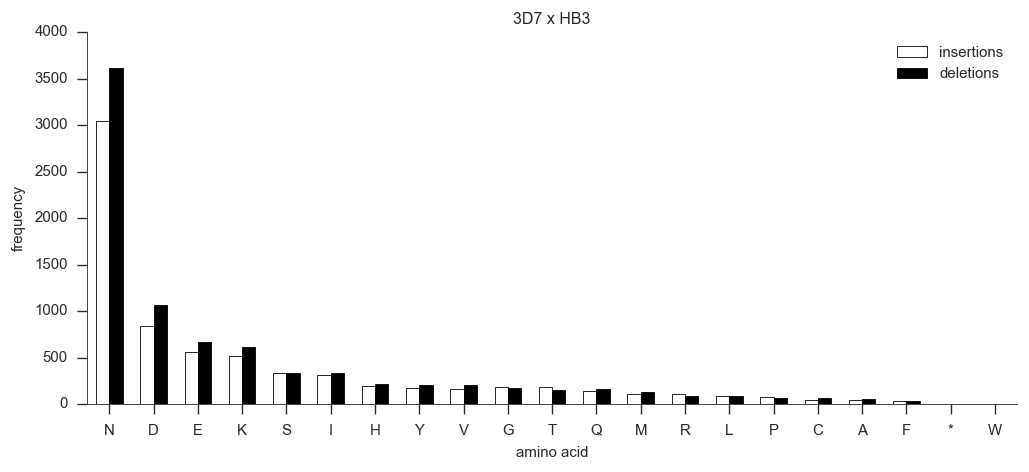

In [11]:
cross = '3d7_hb3'
fig, ax = plt.subplots(figsize=(10, 4))
plot_indel_aa_frequencies(ax, cross=cross)
ax.set_title(LABELS[cross]);

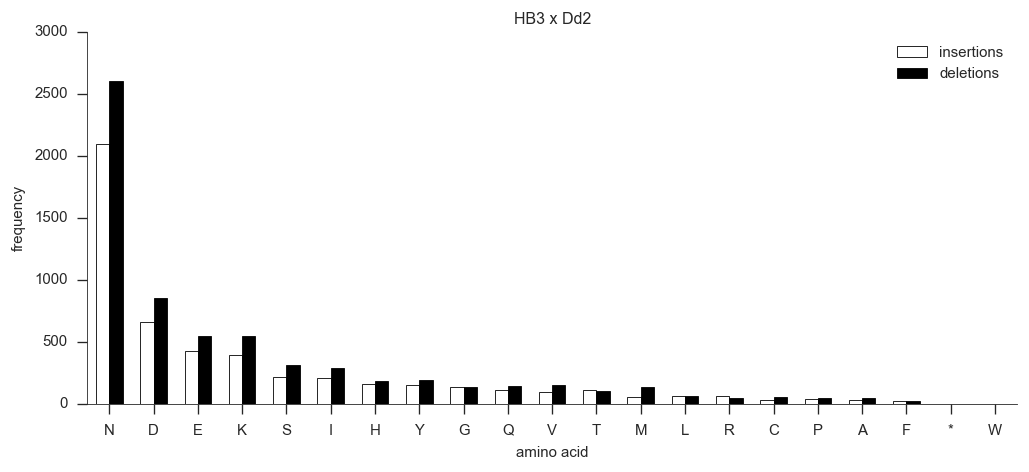

In [12]:
cross = 'hb3_dd2'
fig, ax = plt.subplots(figsize=(10, 4))
plot_indel_aa_frequencies(ax, cross=cross)
ax.set_title(LABELS[cross]);

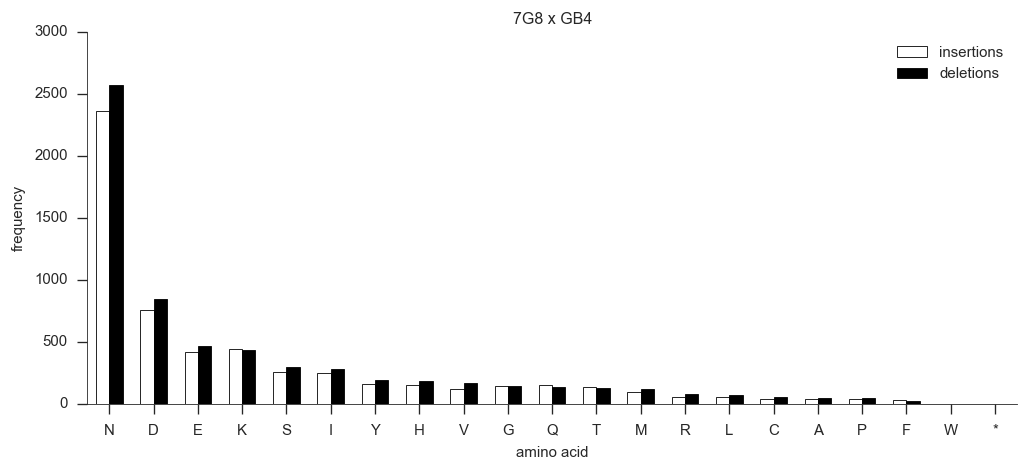

In [13]:
cross = '7g8_gb4'
fig, ax = plt.subplots(figsize=(10, 4))
plot_indel_aa_frequencies(ax, cross=cross)
ax.set_title(LABELS[cross]);

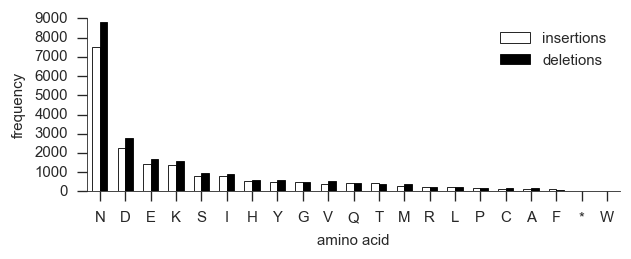

In [14]:
width = 8 * (2/3)
height = (width / 2) / 1.2
fig, ax = plt.subplots(figsize=(width, height))
plot_indel_aa_frequencies(ax)
fig.tight_layout()
fig.savefig('../../artwork/main/fig1B.jpg', dpi=1200, jpeg_quality=100);